# Прогнозирование температуры звезды

## Описание проекта
**Задача от обсерватории «Небо на ладони»**: разработать нейросеть для определения температуры на поверхности обнаруженных звёзд.

### Цель проекта
Создать модель машинного обучения, которая будет предсказывать абсолютную температуру звезды на основе её характеристик.

---

## Традиционные методы расчёта температуры
Обычно учёные используют:
1. **Закон смещения Вина**
2. **Закон Стефана-Больцмана** 
3. **Спектральный анализ**

Каждый метод имеет преимущества и недостатки. ML-подход должен стать более точной и удобной альтернативой.

---

## Данные для обучения
В базе обсерватории есть характеристики **240 изученных звёзд**:

### Признаки звезды:
| Признак | Описание |
|---------|-----------|
| **Относительная светимость** | L/Lo - светимость звезды относительно Солнца |
| **Относительный радиус** | R/Ro - радиус звезды относительно радиуса Солнца |
| **Абсолютная звёздная величина** | Mv - физическая величина, характеризующая блеск звезды |
| **Звёздный цвет** | white, red, blue, yellow, yellow-orange и др. |
| **Тип звезды** | Категориальный признак |

### Типы звезд:
| Тип звезды | Числовой код |
|------------|--------------|
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

### Целевая переменная:
- **Абсолютная температура T(K)** - температура на поверхности звезды в Кельвинах

# Импортируем библиотеки

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import seaborn as sns
import re
import warnings
import logging
import os
from tqdm import tqdm


# === Библиотеки ML ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch.optim as optim
import torch
import torch.nn as nn
import optuna

# === Sklearn ===
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.feature_selection import SelectKBest, f_regression

# === Функции проекта ===
from func import (
    EarlyStoppingCallback,
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_results,
    plot_categorical_columns
)

# === Настройки ===
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    module="sklearn.feature_selection._univariate_selection",
)
warnings.filterwarnings("ignore", category=UserWarning, module="shap")

logging.getLogger("sklearn").setLevel(logging.ERROR)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)

# Константы

In [68]:
# зафиксируем константы
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_ITER = 300
STD_EPOCH = 10000
EARLY_STOP = 200

torch.manual_seed(42)
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Загрузка данных

In [69]:
df = pd.read_csv("../data/6_class.csv")

# Анализ и предобработка данных

In [70]:
df = check_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unnamed:_0               240 non-null    int64  
 1   temperature_(_k)         240 non-null    int64  
 2   luminosity(_l/_lo)       240 non-null    float64
 3   radius(_r/_ro)           240 non-null    float64
 4   absolute_magnitude(_mv)  240 non-null    float64
 5   star_type                240 non-null    int64  
 6   star_color               240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


None

,unnamed:_0,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
24,24,16500,0.01300,0.014,11.89,2,blue white
6,6,2637,0.00073,0.127,17.22,0,red
93,93,4980,0.35700,1.130,4.78,3,yellowish
109,109,33421,352000.00000,67.000,-5.79,4,blue
104,104,11096,112000.00000,12.000,-5.91,4,blue


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
temperature_(_k),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity(_l/_lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius(_r/_ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
absolute_magnitude(_mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
star_type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [71]:
# опять непонятный unnamed:_0 который дублирует индекс
df = df.drop(columns=['unnamed:_0'])

Пропусков нет, но есть цвет звезды - проверим

In [72]:
df['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

Так и оказалось, заполняли непонятно как... приведем неявные дубликаты к общему виду и немного наведем красоты

In [73]:
# # пока закоменчу, хочу попробовать не сокращать так сильно выборку

# # PS: как именно обозначал автор цвета звезд, не совсем понятно.
# # Возьмем первое слово = преобладающий цвет
# color_mapping = {
#     'blue': 'blue',
#     'blue white': 'blue', 
#     'blue-white': 'blue',
    
#     'white': 'white',
#     'whitish': 'white',
#     'white-yellow': 'white',
    
#     'yellow-white': 'yellow',
#     'yellowish': 'yellow',
#     'yellowish white': 'yellow',
#     'pale yellow orange': 'yellow',
    
#     'orange': 'orange',
#     'orange-red': 'red',
    
#     'red': 'red'
# }

# df['star_color'] = df['star_color'].str.strip().str.lower().replace(color_mapping)
# df['star_color'].unique()

In [74]:
color_mapping = {
    'blue white': 'blue_white', 
    'blue-white': 'blue_white',
    'white-yellow': 'white_yellow',
    'yellow-white': 'white_yellow',
    'yellowish white': 'yellowish_white',
    'orange-red': 'orange_red',
    'pale yellow orange': 'pale_yellow_orange',
}

df['star_color'] = df['star_color'].str.strip().str.lower().replace(color_mapping)
df['star_color'].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'white_yellow', 'orange',
       'yellowish', 'orange_red'], dtype=object)

In [75]:
df.sample(5)

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
58,3752,209000.00000,955.0000,-11.24,5,red
84,14100,0.00067,0.0089,12.17,2,blue_white
166,19923,152000.00000,73.0000,-5.69,4,blue
99,36108,198000.00000,10.2000,-4.40,3,blue
198,3324,0.00650,0.4710,12.78,1,red


Да, цвет звезды не совсем бьется с ее "цветовым типом", но в целом все логично.

In [76]:
# и теперь проверим явные дубликаты после корректировок
df = drop_duplicated(df)

np.int64(0)

'Дубликаты отсутствуют'

Посмотрим на распределение

2025-11-12 19:44:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-12 19:44:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


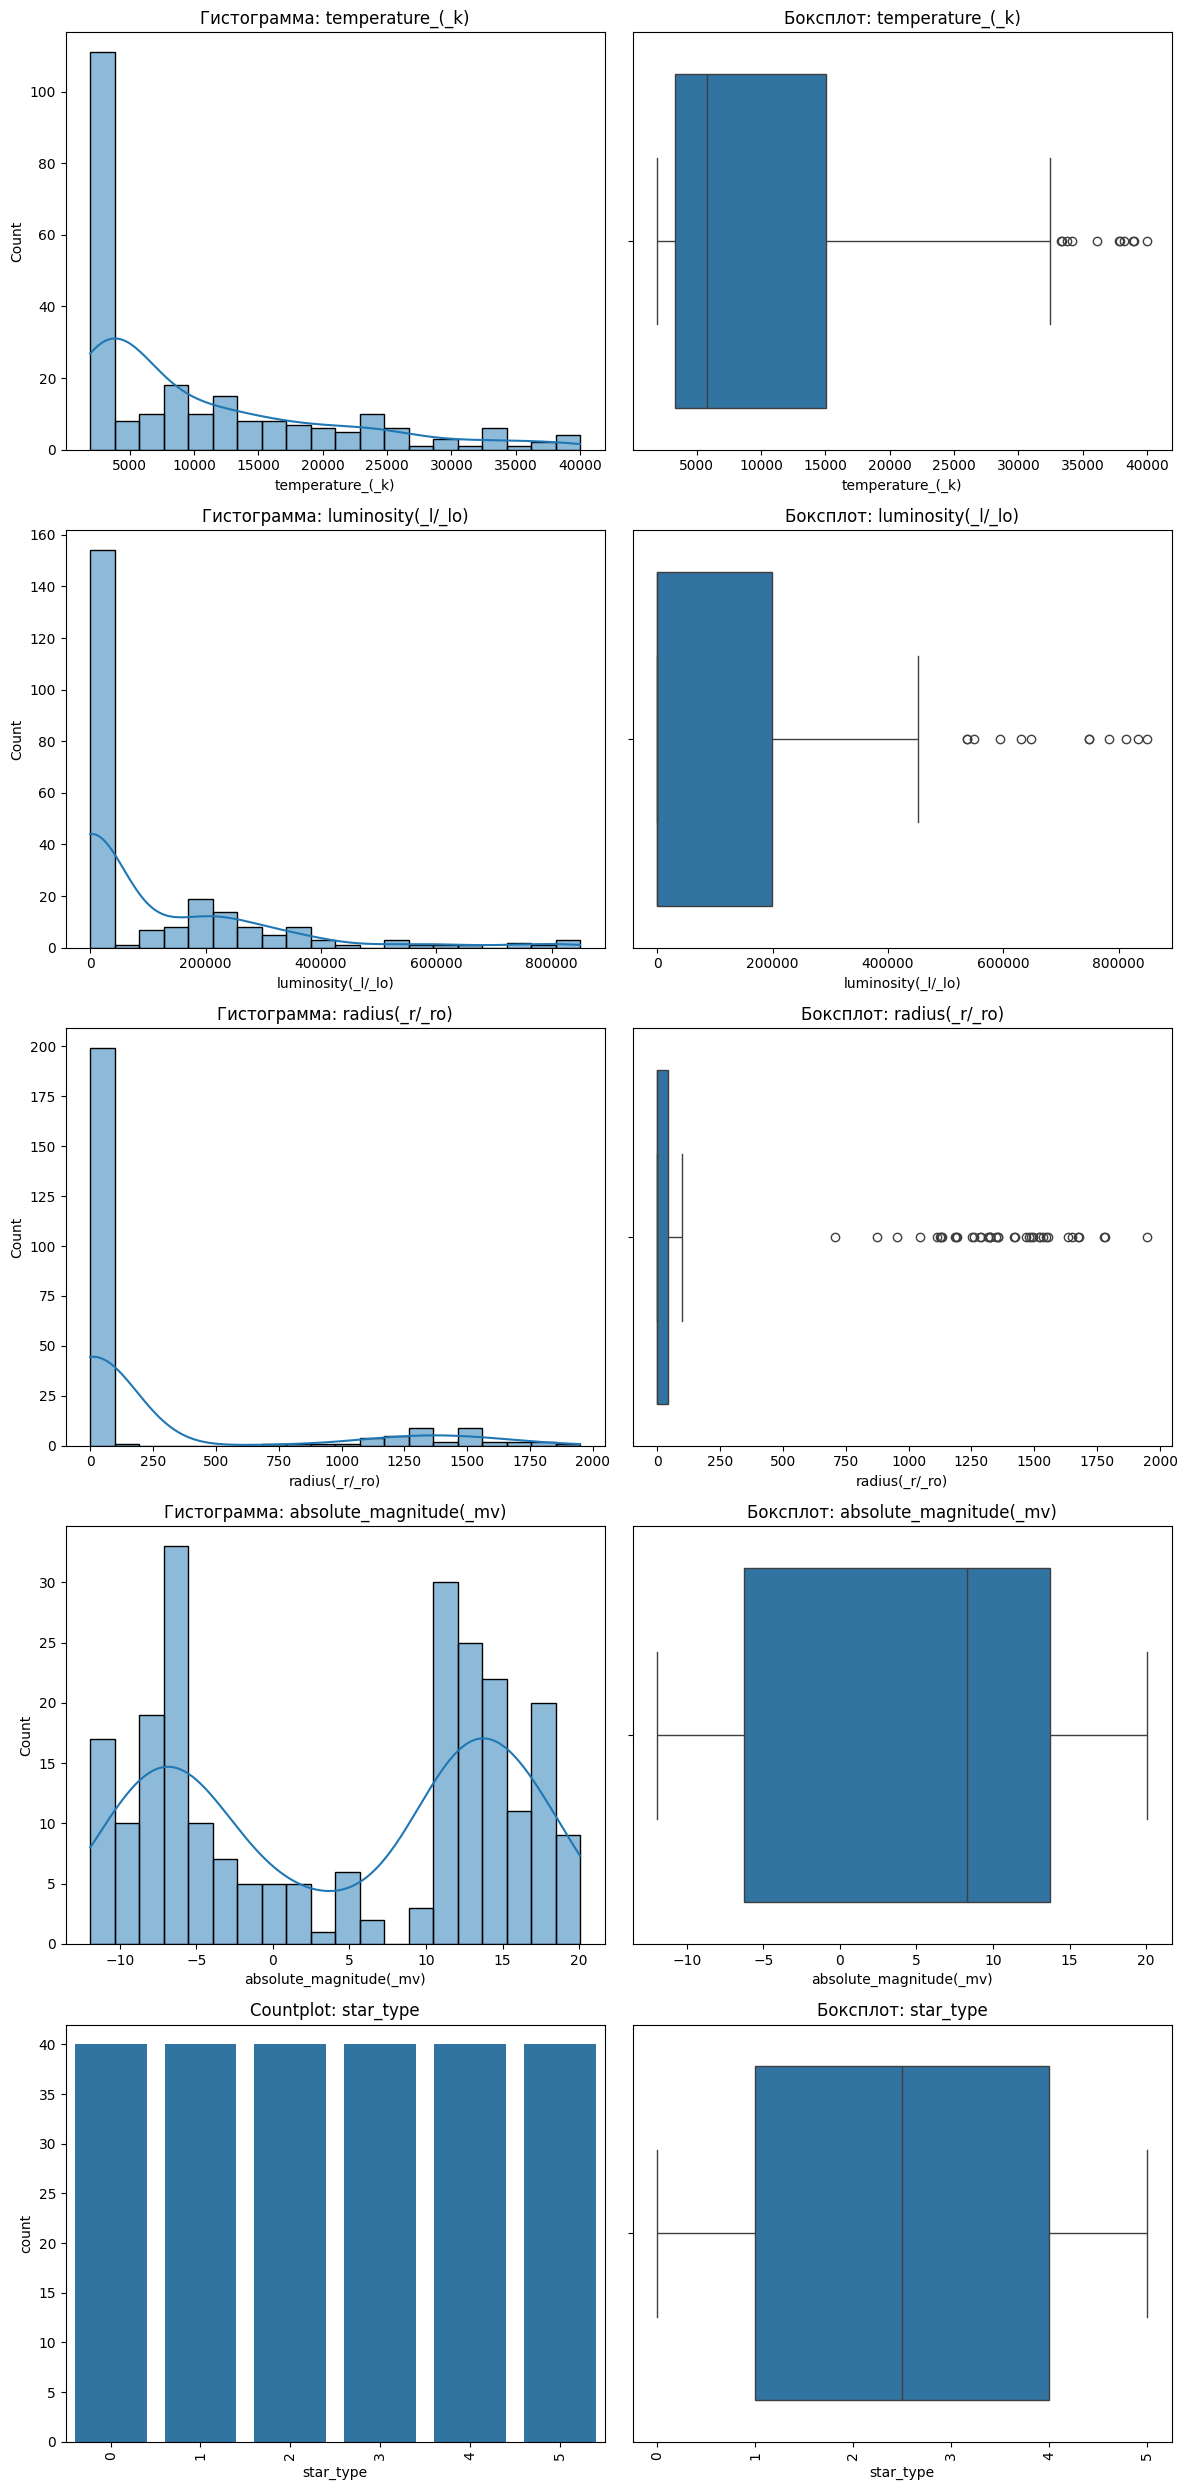

In [77]:
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

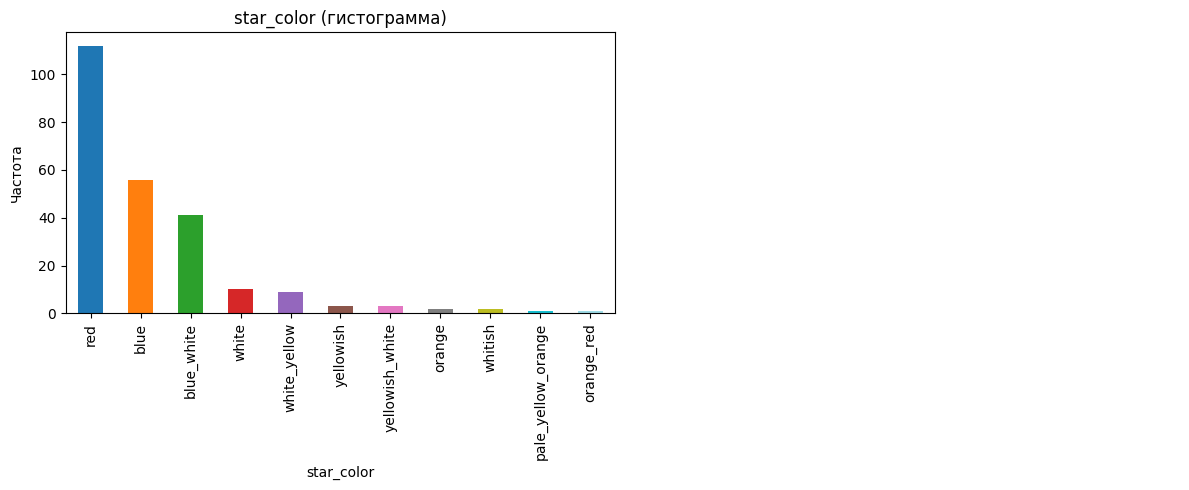

In [78]:
plot_categorical_columns(df, col=None, target=None)

Распределение по типу звёзд оказалось идеальным, прекрасно.  
А вот остальные признаки требуют дополнительного изучения и, наверное, обработки.

In [79]:
# очень много данных temperature_(_k) меньше 5000, посмотрим на них отдельно
df_low_temp = df[df['temperature_(_k)'] < 2000]
df_low_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
4,1939,0.000138,0.103,20.06,0,red


Нулевых нет и на том спасибо.  
К томуже справочный материал говорит, что такая температура вполне возможна.

In [80]:
# и выбросы по высокой температуре
df_high_temp = df[df['temperature_(_k)'] > 35000]
df_high_temp

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
30,39000,204000.0,10.60,-4.70,3,blue
99,36108,198000.0,10.20,-4.40,3,blue
101,40000,813000.0,14.00,-6.23,4,blue
159,37800,202900.0,6.86,-4.56,3,blue
231,38234,272830.0,1356.00,-9.29,5,blue
235,38940,374830.0,1356.00,-9.93,5,blue
239,37882,294903.0,1783.00,-7.80,5,blue


Вопросики по светимости к типу 4 да и в целом все еще непонятно определение цвета звезд.  
Разные типы, разные размеры, разные светимости....  
Ничего непонятно, но очень интересно :)

Теперь свечение luminosity(_l/_lo)

In [81]:
df_low_lum = df[df['luminosity(_l/_lo)'] < 100]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.17000,16.120,0,red
1,3042,0.000500,0.15420,16.600,0,red
2,2600,0.000300,0.10200,18.700,0,red
3,2800,0.000200,0.16000,16.650,0,red
4,1939,0.000138,0.10300,20.060,0,red
...,...,...,...,...,...,...
207,23092,0.001320,0.01040,10.180,2,blue
208,17920,0.001110,0.01060,11.660,2,blue
209,19360,0.001250,0.00998,11.620,2,blue
216,9320,29.000000,1.91000,1.236,3,blue_white


In [82]:
df_low_lum = df[df['luminosity(_l/_lo)'] > 500000]
df_low_lum

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
53,3749,550000.0,1648.0,-8.050,5,orange
101,40000,813000.0,14.0,-6.230,4,blue
172,4287,630000.0,1315.0,-9.200,5,orange
223,23440,537430.0,81.0,-5.975,4,blue
226,9892,593900.0,80.0,-7.262,4,blue
227,10930,783930.0,25.0,-6.224,4,blue
229,21738,748890.0,92.0,-7.346,4,blue
232,32489,648430.0,1948.5,-10.840,5,blue
233,27739,849420.0,1252.0,-7.590,5,blue_white
234,21904,748490.0,1130.0,-7.670,5,blue_white


Вот о чем и писал выше - светимость огромная, а температура может быть не очень высокой.

Так как у нас идет сравнение с Солнцем, что оставим как есть.  

Радиус radius(_r/_ro) скорее всего покажет схожую картину, но посмотрим.

In [83]:
df_low_rad = df[df['radius(_r/_ro)'] < 100]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
0,3068,0.002400,0.1700,16.120,0,red
1,3042,0.000500,0.1542,16.600,0,red
2,2600,0.000300,0.1020,18.700,0,red
3,2800,0.000200,0.1600,16.650,0,red
4,1939,0.000138,0.1030,20.060,0,red
...,...,...,...,...,...,...
225,18734,224780.000000,46.0000,-7.450,4,blue
226,9892,593900.000000,80.0000,-7.262,4,blue
227,10930,783930.000000,25.0000,-6.224,4,blue
228,23095,347820.000000,86.0000,-5.905,4,blue


In [84]:
df_low_rad = df[df['radius(_r/_ro)'] > 200]
df_low_rad

,temperature_(_k),luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color
50,3490,270000.0,1520.0,-9.40,5,red
51,3750,283000.0,1260.0,-7.63,5,red
52,3834,272000.0,1183.0,-9.20,5,red
53,3749,550000.0,1648.0,-8.05,5,orange
54,3650,310000.0,1324.0,-7.79,5,red
55,3450,263000.0,1349.0,-11.75,5,red
56,3660,363000.0,1673.0,-11.92,5,red
57,3450,174000.0,1284.0,-11.28,5,red
58,3752,209000.0,955.0,-11.24,5,red
59,3535,195000.0,1546.0,-11.36,5,red


'=== Корреляция с таргетом ==='

star_color                -0.724016
absolute_magnitude(_mv)   -0.420261
star_type                  0.411129
luminosity(_l/_lo)         0.393404
radius(_r/_ro)             0.064216
Name: temperature_(_k), dtype: float64

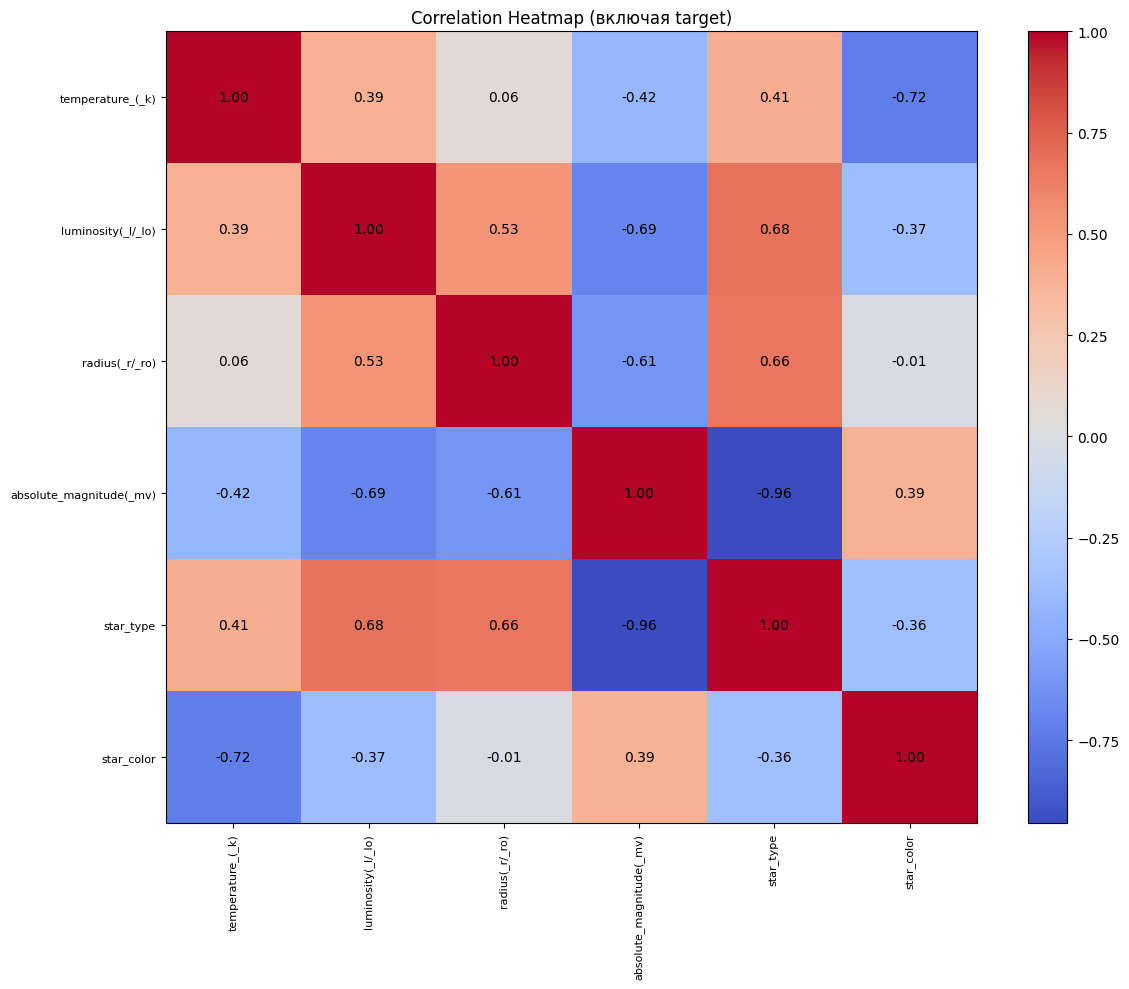

'=== VIF ==='

,feature,VIF
2,absolute_magnitude(_mv),9.207969
3,star_type,5.916273
0,luminosity(_l/_lo),2.796435
1,radius(_r/_ro),2.059523
4,star_color,1.700338


In [85]:
calc_target_correlations(df, target_col="temperature_(_k)")

Мультиколлинеарности не наблюдается.  
VIF в пределах допустимого.

## Выводы по анализу данных

**Основные проблемы в данных о звездах**  

*Несоответствие температуры и цвета*  
- Холодные звезды указаны с цветами, характерными для горячих звезд  
- Нарушена физическая связь между температурой и спектральным классом  

*Нарушение астрофизических законов*  
- Не соблюдается закон Стефана-Больцмана (связь светимости с радиусом и температурой)  
- Параметры светимости и радиуса противоречат друг другу  

*Статистические аномалии*  
- Слишком много редких типов звезд (гипергигантов)  
- Нарушены реальные пропорции встречаемости разных классов звезд  

*Проблемы с классификацией*  
- Цвета звезд не соответствуют их физическим параметрам  
- Отсутствует системный подход к классификации по спектральным классам  
- Произвольное сочетание характеристик без физического обоснования  

*Методологические проблемы*  
- Данные выглядят сгенерированными, а не наблюдаемыми  
- Отсутствует внутренняя согласованность параметров  
- Нарушены известные астрофизические зависимости  

В целом: Данные требуют серьезной доработки для соответствия реальным астрономическим закономерностям.  
Но ввиду того, что это учебный проект, будем работать с тем, что есть.  

# Построение базовой нейронной сети

## Разделение данных на признаки и целевой признак

In [86]:
# разделим на выборки их оставшихся данных
target = 'temperature_(_k)'
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target], axis=1),
    df[target],
    shuffle=True,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [87]:
# разделяем признаки с учетом ordinal переменной
def custom_selector(X):
    """Для разделения признаков"""
    cat_cols = []
    ord_cols = ['star_type']  # явно указываем ordinal признаки
    num_cols = []
    
    for col in X.columns:
        if col in ord_cols:
            continue
        elif X[col].dtype in ['object', 'category']:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    
    return num_cols, cat_cols, ord_cols

num_cols, cat_cols, ord_cols = custom_selector(X_train)

display("Числовые:", num_cols)
display("Категориальные (nominal):", cat_cols)
display("Порядковые (ordinal):", ord_cols)

'Числовые:'

['luminosity(_l/_lo)', 'radius(_r/_ro)', 'absolute_magnitude(_mv)']

'Категориальные (nominal):'

['star_color']

'Порядковые (ordinal):'

['star_type']

In [88]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("to_str", FunctionTransformer(lambda x: x.astype(str))),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
        ]), cat_cols),
        ("ord", Pipeline([
            ("scaler", StandardScaler())
        ]), ord_cols)
    ]
)

In [89]:
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

preprocessing_pipeline.fit(X_train)

X_train_processed = preprocessing_pipeline.transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# посмотри как все нормализовалось после пайплайна
cat_encoder = preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)

feature_names = (
    list(num_cols)
    + list(cat_feature_names)
    + list(ord_cols)
)

X_train_transformed_df = pd.DataFrame(X_train_processed, columns=feature_names)
display(X_train_transformed_df.sample(10))

,luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_color_blue_white,star_color_pale_yellow_orange,star_color_red,star_color_white,star_color_white_yellow,star_color_whitish,star_color_yellowish,star_color_yellowish_white,star_type
86,1.581180,2.293740,-1.371374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.507250
67,-0.588248,-0.446050,0.817058,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.273746
153,1.396608,-0.248058,-1.089458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.913585
116,-0.588248,-0.445813,1.255700,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.461076
87,-0.588248,-0.445805,1.111397,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.461076
138,0.990828,2.293740,-1.310213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.507250
31,-0.588248,-0.445801,1.214607,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.461076
40,1.263837,-0.387473,-1.053144,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.913585
46,-0.588248,-0.446042,0.923134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.273746
62,-0.588248,-0.444593,0.987163,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.867411


In [90]:
# все отлично
# конвертируем в тензоры
X_train_tensor = torch.FloatTensor(X_train_processed)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

In [91]:
display(preprocessing_pipeline)

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Построение простой модели нейронной сети — baseline

## Создаем класс для задания архитектуры нейронной сети

baseline сделаю самый простой, чтобы потом было с чем сравнивать  
1 скрытый слой, немного нейронов и общепринятые функции активации и потерь

In [92]:
# сделаем baseline
class StarTemperatureNet(nn.Module):
    def __init__(self, input_size):
        super(StarTemperatureNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

def train_model_simple(model, X_train, y_train, X_test, y_test, epochs=500):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train)
        train_loss = criterion(predictions, y_train.unsqueeze(1))
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test.unsqueeze(1))
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        if epoch % 2000 == 0:
            logger.info(f'Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses

input_size = X_train_tensor.shape[1]
logger.info(f"Размер входных данных: {input_size}")

model = StarTemperatureNet(input_size=input_size)
logger.info(model)

total_params = sum(p.numel() for p in model.parameters())
logger.info(f"Всего параметров: {total_params}")

logger.info("Начинаем обучение baseline...")
train_losses, test_losses = train_model_simple(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_test_tensor, 
    y_test_tensor,
    epochs=STD_EPOCH
)


2025-11-12 19:44:07 [INFO] __main__: Размер входных данных: 12
2025-11-12 19:44:07 [INFO] __main__: StarTemperatureNet(
  (layer1): Linear(in_features=12, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
2025-11-12 19:44:07 [INFO] __main__: Всего параметров: 449
2025-11-12 19:44:07 [INFO] __main__: Начинаем обучение baseline...
2025-11-12 19:44:07 [INFO] __main__: Epoch 0, Train Loss: 203356800.0000, Test Loss: 194172160.0000
2025-11-12 19:44:08 [INFO] __main__: Epoch 2000, Train Loss: 44774936.0000, Test Loss: 58723840.0000
2025-11-12 19:44:10 [INFO] __main__: Epoch 4000, Train Loss: 27864710.0000, Test Loss: 47954468.0000
2025-11-12 19:44:11 [INFO] __main__: Epoch 6000, Train Loss: 18184840.0000, Test Loss: 53856744.0000
2025-11-12 19:44:13 [INFO] __main__: Epoch 8000, Train Loss: 15193690.0000, Test Loss: 58387456.0000


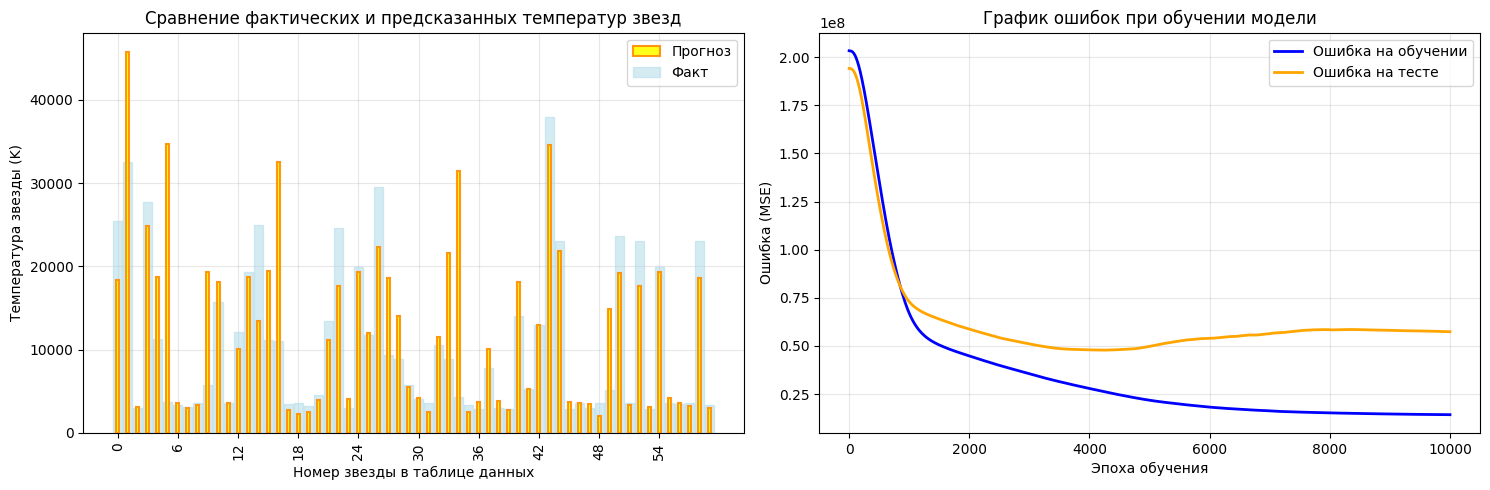

2025-11-12 19:44:14 [INFO] func: Средняя абсолютная ошибка (MAE): 4063.78 K
2025-11-12 19:44:14 [INFO] func: Среднеквадратичная ошибка (RMSE): 7574.52 K
2025-11-12 19:44:14 [INFO] func: Коэффициент детерминации (R²): 0.3131
2025-11-12 19:44:14 [INFO] func: Средняя температура: 10519.20 K
2025-11-12 19:44:14 [INFO] func: Стандартное отклонение: 9139.18 K
2025-11-12 19:44:14 [INFO] func: 
Первые 10 предсказаний:


,luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color,actual_temperature,predicted_temperature,absolute_error
0,223000.00000,57.0000,-5.92,4,blue,25390.0,18331.035156,7058.964844
1,648430.00000,1948.5000,-10.84,5,blue,32489.0,45781.414062,13292.414062
2,0.00032,0.0930,18.34,0,red,2945.0,3140.333984,195.333984
3,849420.00000,1252.0000,-7.59,5,blue_white,27739.0,24857.345703,2881.654297
4,672.00000,6.9800,-2.30,3,blue_white,11250.0,18707.554688,7457.554688
5,550000.00000,1648.0000,-8.05,5,orange,3749.0,34712.851562,30963.851562
6,0.00043,0.0912,17.16,0,red,3323.0,3583.498535,260.498535
7,0.00880,0.3500,11.94,1,red,3150.0,3000.041504,149.958496
8,74000.00000,876.0000,-10.25,5,red,3625.0,3396.345703,228.654297
9,245000.00000,97.0000,-6.63,4,blue,5752.0,19311.681641,13559.681641


2025-11-12 19:44:14 [INFO] func: 
Статистика по ошибкам предсказания:


count       60.000000
mean      4063.779053
std       6446.056152
min         10.050781
25%        309.268311
50%        947.549805
75%       5317.326904
max      30963.851562
Name: absolute_error, dtype: float64

In [93]:
mae, rmse, r2, df_pred = plot_results(
    model, 
    X_test_tensor, 
    y_test_tensor, 
    train_losses, 
    test_losses,
    X_test_original=X_test
)

Вот такой получился baseline вариант модели нейронной сети.  
Модель работает, модель что-то даже считает и что-то даже предсказывает.  
Но пока что качество оставляет желать лучшего, к тому же она явно переобучилась без использования ранней остановки.  
Перейдем более углубленному и осознанному подбору гиперпараметров и архитектуры модели.  

# Улучшение нейронной сети

А теперь попробуем улучшить нашу модель.  
Сделаем больше слоев, добавим регуляризацию и попробуем разные функции активации.  
Может быть, еще, что-то придумаем.

In [94]:
# сделаем класс
class StarTemperatureNetFlexible(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.0, activation='relu'):
        super().__init__()
        layers = []
        prev_size = input_size
        act_map = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'elu': nn.ELU(),
            'selu': nn.SELU(),
            'gelu': nn.GELU()
        }
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(act_map[activation])
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            prev_size = size
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [95]:
# вместо функции ошибки будем использовать RMSE с отслеживанием лучшей модели
# не знаю можно так делать или нет но мне так кажется удобнее :)
def train_model_with_tracking(model, X_train_t, y_train_t, X_test_t, y_test_t,
                              epochs=2000, lr=1e-3, patience=200, weight_decay=1e-5, device='cpu',
                              optimizer_type='Adam', scheduler_params=None, batch_size=64):
    
    if scheduler_params is None:
        scheduler_params = {"factor": 0.5, "patience": 20}

    model.to(device)
    X_train, y_train = X_train_t.to(device), y_train_t.to(device)
    X_test, y_test = X_test_t.to(device), y_test_t.to(device)

    criterion = nn.MSELoss()

    # выбор оптимизатора
    if optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    factor = scheduler_params.get("factor", 0.5)
    patience_lr = scheduler_params.get("patience", 20)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience_lr, factor=factor)

    best_rmse, patience_counter, best_state = float('inf'), 0, None
    train_losses, test_losses = [], []

    n_samples = X_train.size(0)
    n_batches = (n_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n_samples)
        epoch_loss = 0

        for i in range(n_batches):
            idx = perm[i * batch_size: (i + 1) * batch_size]
            batch_x, batch_y = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            preds_test = model(X_test)
            test_rmse = np.sqrt(criterion(preds_test, y_test.unsqueeze(1)).item())

        train_rmse = np.sqrt(epoch_loss / n_batches)
        train_losses.append(train_rmse)
        test_losses.append(test_rmse)

        if test_rmse < best_rmse:
            best_rmse, patience_counter = test_rmse, 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # logger.info(f"Ранняя остановка на эпохе {epoch}, лучший RMSE={best_rmse:.6f}")
                break

        # if epoch % 2000 == 0:
        #     logger.info(f"Эпоха {epoch}, RMSE на тесте = {test_rmse:.6f}")

        scheduler.step(test_rmse)

    if best_state:
        model.load_state_dict(best_state)
        model.to(device)

    return best_rmse, model, train_losses, test_losses

In [96]:
# подбирать буду через Optuna которая себя хорошо зарекомендовала в прошлых проектах и давала хорошие результаты
# подготовим objective функцию и сетку гиперпараметров для оптимизации
def objective(trial):
    X_train_np = X_train_tensor.cpu().numpy()
    X_test_np = X_test_tensor.cpu().numpy()
    y_train_np = y_train_tensor.cpu().numpy().ravel()

    n_features = X_train_np.shape[1]
    k_features = trial.suggest_int("k_features", 2, n_features)

    selector = SelectKBest(f_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_np, y_train_np)
    X_test_sel = selector.transform(X_test_np)

    X_train_sel_t = torch.tensor(X_train_sel, dtype=torch.float32)
    X_test_sel_t = torch.tensor(X_test_sel, dtype=torch.float32)
    y_train_t, y_test_t = y_train_tensor.clone(), y_test_tensor.clone()

    n_layers = trial.suggest_int('n_layers', 1, 8)
    hidden_sizes = [
        trial.suggest_categorical(f'n_units_l{i}', [32, 64, 128, 256, 512, 1024, 2048])
        for i in range(n_layers)
    ]

    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu', 'selu', 'gelu'])
    optimizer_type = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop'])

    # новый параметр — размер батча
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512])

    scheduler_params = {
        "factor": trial.suggest_float("lr_factor", 0.3, 0.8),
        "patience": trial.suggest_int("lr_patience", 10, 50)
    }

    model = StarTemperatureNetFlexible(
        X_train_sel.shape[1], hidden_sizes, dropout_rate, activation
    )

    best_rmse, _, train_losses, test_losses = train_model_with_tracking(
        model,
        X_train_sel_t, y_train_t, X_test_sel_t, y_test_t,
        epochs=STD_EPOCH, lr=learning_rate, patience=EARLY_STOP,
        weight_decay=weight_decay, device=device,
        optimizer_type=optimizer_type, scheduler_params=scheduler_params,
        batch_size=batch_size
    )

    trial.set_user_attr("hidden_sizes", hidden_sizes)
    trial.set_user_attr("k_features", k_features)
    trial.set_user_attr("batch_size", batch_size)

    return best_rmse


In [97]:
# # и сделаем функцию для запуска оптимизации и сбора результатов в таблицу
# def run_optuna_and_report(X_train_t, y_train_t, X_test_t, y_test_t, n_trials=30):
#     global X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
#     X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = X_train_t, y_train_t, X_test_t, y_test_t

#     optuna.logging.set_verbosity(optuna.logging.WARNING)
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=n_trials)

#     rows = []
#     for t in study.trials:
#         if t.value is None:
#             continue
#         r = dict(t.params)
#         hidden = [r[k] for k in sorted([k for k in r.keys() if k.startswith('n_units_l')],
#                                        key=lambda x: int(x.split('l')[-1]))]
#         r['hidden_sizes'] = hidden
#         r['k_features'] = t.user_attrs.get('k_features')
#         r['rmse'] = t.value
#         rows.append(r)

#     df_results = pd.DataFrame(rows).sort_values('rmse').reset_index(drop=True)
#     df_results.to_csv('optuna_trials_results.csv', index=False)
#     logger.info("Результаты экспериментов сохранены в optuna_trials_results.csv")

#     logger.info(f"Лучший RMSE: {study.best_value:.6f}")
#     logger.info(f"Лучшие параметры: {study.best_params}")
#     logger.info("\nТоп-5 конфигураций по RMSE")
#     logger.info(df_results.head(5).to_string(index=False))

#     return study, df_results

def run_optuna_and_report(X_train_t, y_train_t, X_test_t, y_test_t, n_trials=30):
    global X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = X_train_t, y_train_t, X_test_t, y_test_t

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize')

    # tqdm по триалам
    for _ in tqdm(range(n_trials), desc="Оптуна (триалы)"):
        study.optimize(objective, n_trials=1)

    rows = []
    for t in study.trials:
        if t.value is None:
            continue
        r = dict(t.params)
        hidden = [r[k] for k in sorted([k for k in r.keys() if k.startswith('n_units_l')],
                                       key=lambda x: int(x.split('l')[-1]))]
        r['hidden_sizes'] = hidden
        r['k_features'] = t.user_attrs.get('k_features')
        r['rmse'] = t.value
        rows.append(r)

    df_results = pd.DataFrame(rows).sort_values('rmse').reset_index(drop=True)
    df_results.to_csv('optuna_trials_results.csv', index=False)
    logger.info("Результаты экспериментов сохранены в optuna_trials_results.csv")
    logger.info(f"Лучший RMSE: {study.best_value:.6f}")
    logger.info(f"Лучшие параметры: {study.best_params}")

    return study, df_results

In [98]:
# после всех экспериментов мы получили лучшие показатели гиперпараметров, на который сейчас и обучим модель с последующим сохранением и визуализацией
def train_and_plot_best(study, X_train_t, y_train_t, X_test_t, y_test_t, X_test_original=None):
    best_params = study.best_params
    hidden_sizes = [best_params[k] for k in sorted([k for k in best_params.keys() if k.startswith('n_units_l')],
                                                   key=lambda x: int(x.split('l')[-1]))]
    k_features = study.best_trial.user_attrs['k_features']

    optimizer_type = best_params.get('optimizer', 'Adam')
    scheduler_params = {
        "factor": best_params.get('lr_factor', 0.5),
        "patience": best_params.get('lr_patience', 20)
    }

    X_train_np, X_test_np, y_train_np = X_train_t.cpu().numpy(), X_test_t.cpu().numpy(), y_train_t.cpu().numpy().ravel()
    selector = SelectKBest(f_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_np, y_train_np)
    X_test_sel = selector.transform(X_test_np)

    X_train_sel_t = torch.tensor(X_train_sel, dtype=torch.float32).to(device)
    X_test_sel_t = torch.tensor(X_test_sel, dtype=torch.float32).to(device)
    y_train_t = y_train_t.to(device)
    y_test_t = y_test_t.to(device)

    model = StarTemperatureNetFlexible(X_train_sel.shape[1], hidden_sizes,
                                       dropout_rate=best_params['dropout_rate'], 
                                       activation=best_params['activation']).to(device)

    best_rmse, trained_model, train_losses, test_losses = train_model_with_tracking(
        model, X_train_sel_t, y_train_t, X_test_sel_t, y_test_t,
        epochs=STD_EPOCH, 
        lr=best_params['learning_rate'], 
        patience=EARLY_STOP, 
        weight_decay=best_params['weight_decay'],
        device=device,
        optimizer_type=optimizer_type,
        scheduler_params=scheduler_params
    )

    mae, rmse, r2, df_pred = plot_results(
        trained_model, X_test_sel_t, y_test_t, train_losses, test_losses, X_test_original
    )

    logger.info(f"Лучший RMSE после оптуны: {study.best_value:.6f}")
    logger.info(f"Финальный RMSE: {rmse:.6f}")
    logger.info(f"MAE: {mae:.6f}, R²: {r2:.6f}")

    logger.info(f"Использованный оптимизатор: {optimizer_type}")
    logger.info(f"Использован планировщик: factor={scheduler_params['factor']}, patience={scheduler_params['patience']}")

    if abs(rmse - study.best_value) / study.best_value < 0.1:
        logger.info("Результаты финального обучения близки к лучшим результатам Optuna")
    else:
        logger.info("Результаты финального обучения отличаются от лучших результатов Optuna")

    torch.save(trained_model.state_dict(), 'best_model.pth')
    logger.info("Лучшая модель сохранена в best_model.pth")

    return trained_model, mae, rmse, r2, df_pred

2025-11-12 19:44:15 [INFO] __main__: Используется: cuda
Оптуна (триалы): 100%|██████████| 300/300 [1:05:13<00:00, 13.05s/it]
2025-11-12 20:49:28 [INFO] __main__: Результаты экспериментов сохранены в optuna_trials_results.csv
2025-11-12 20:49:28 [INFO] __main__: Лучший RMSE: 4084.216449
2025-11-12 20:49:28 [INFO] __main__: Лучшие параметры: {'k_features': 4, 'n_layers': 6, 'n_units_l0': 256, 'n_units_l1': 256, 'n_units_l2': 1024, 'n_units_l3': 2048, 'n_units_l4': 128, 'n_units_l5': 2048, 'dropout_rate': 0.032613959692925756, 'learning_rate': 0.00629187232409946, 'weight_decay': 9.215735862734261e-06, 'activation': 'relu', 'optimizer': 'AdamW', 'batch_size': 64, 'lr_factor': 0.5108254783167131, 'lr_patience': 35}
2025-11-12 20:49:28 [INFO] __main__: 
=== Лучший результат ===
2025-11-12 20:49:28 [INFO] __main__: Лучший RMSE: 4084.216449
2025-11-12 20:49:28 [INFO] __main__:   k_features: 4
2025-11-12 20:49:28 [INFO] __main__:   n_layers: 6
2025-11-12 20:49:28 [INFO] __main__:   n_units_l0:

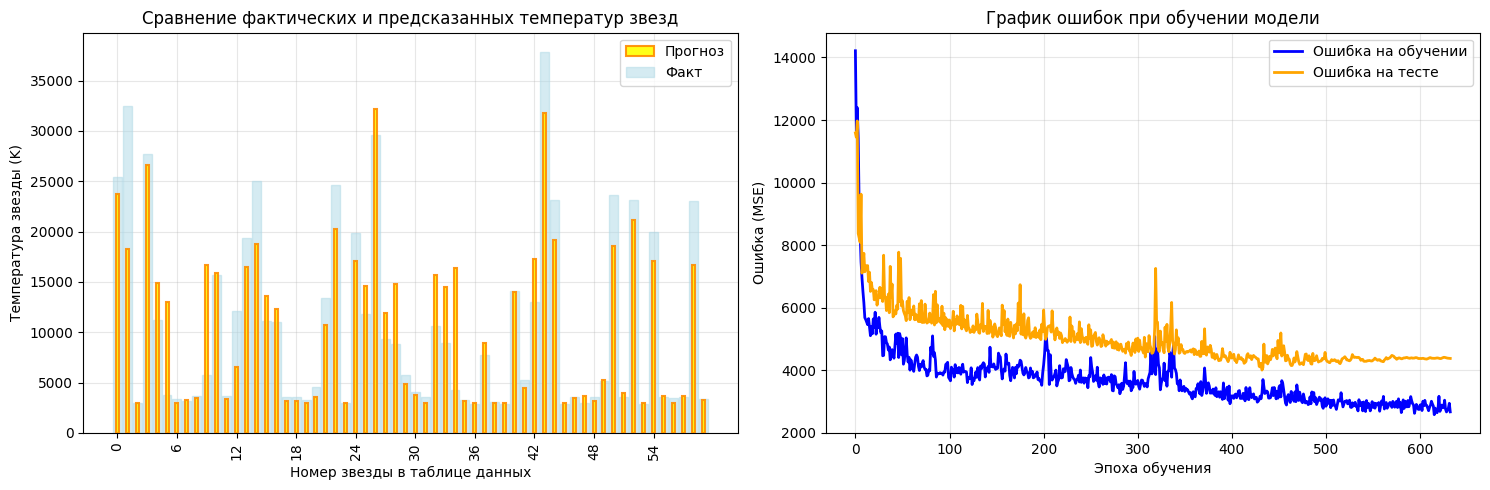

2025-11-12 20:49:37 [INFO] func: Средняя абсолютная ошибка (MAE): 2446.93 K
2025-11-12 20:49:37 [INFO] func: Среднеквадратичная ошибка (RMSE): 4006.86 K
2025-11-12 20:49:37 [INFO] func: Коэффициент детерминации (R²): 0.8078
2025-11-12 20:49:37 [INFO] func: Средняя температура: 10519.20 K
2025-11-12 20:49:37 [INFO] func: Стандартное отклонение: 9139.18 K
2025-11-12 20:49:37 [INFO] func: 
Первые 10 предсказаний:


,luminosity(_l/_lo),radius(_r/_ro),absolute_magnitude(_mv),star_type,star_color,actual_temperature,predicted_temperature,absolute_error
0,223000.00000,57.0000,-5.92,4,blue,25390.0,23726.318359,1663.681641
1,648430.00000,1948.5000,-10.84,5,blue,32489.0,18226.894531,14262.105469
2,0.00032,0.0930,18.34,0,red,2945.0,3002.172119,57.172119
3,849420.00000,1252.0000,-7.59,5,blue_white,27739.0,26579.644531,1159.355469
4,672.00000,6.9800,-2.30,3,blue_white,11250.0,14851.782227,3601.782227
5,550000.00000,1648.0000,-8.05,5,orange,3749.0,13053.908203,9304.908203
6,0.00043,0.0912,17.16,0,red,3323.0,3002.172119,320.827881
7,0.00880,0.3500,11.94,1,red,3150.0,3224.643311,74.643311
8,74000.00000,876.0000,-10.25,5,red,3625.0,3430.003418,194.996582
9,245000.00000,97.0000,-6.63,4,blue,5752.0,16658.990234,10906.990234


2025-11-12 20:49:37 [INFO] func: 
Статистика по ошибкам предсказания:


count       60.000000
mean      2446.934082
std       3199.701660
min         22.854980
25%        188.040466
50%        965.627930
75%       3671.414307
max      14262.105469
Name: absolute_error, dtype: float64

2025-11-12 20:49:37 [INFO] __main__: Лучший RMSE после оптуны: 4084.216449
2025-11-12 20:49:37 [INFO] __main__: Финальный RMSE: 4006.861989
2025-11-12 20:49:37 [INFO] __main__: MAE: 2446.934082, R²: 0.807782
2025-11-12 20:49:37 [INFO] __main__: Использованный оптимизатор: AdamW
2025-11-12 20:49:37 [INFO] __main__: Использован планировщик: factor=0.5108254783167131, patience=35
2025-11-12 20:49:37 [INFO] __main__: Результаты финального обучения близки к лучшим результатам Optuna
2025-11-12 20:49:37 [INFO] __main__: Лучшая модель сохранена в best_model.pth
2025-11-12 20:49:37 [INFO] __main__: Предсказания сохранены в best_model_predictions.csv


In [99]:
# все функции готовы, начинаем эксперимент
logger.info(f"Используется: {device}")
study, df_results = run_optuna_and_report(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, n_trials=N_ITER)

df_results = pd.read_csv('optuna_trials_results.csv') if os.path.exists('optuna_trials_results.csv') else df_results
best_result = df_results.iloc[0]

logger.info("\n=== Лучший результат ===")
logger.info(f"Лучший RMSE: {best_result['rmse']:.6f}")
for param, value in best_result.items():
    if param not in ['rmse', 'hidden_sizes']:
        logger.info(f"  {param}: {value}")

best_model, mae, rmse, r2, df_predictions = train_and_plot_best(
    study, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, X_test
)

df_predictions.to_csv('best_model_predictions.csv', index=False)
logger.info("Предсказания сохранены в best_model_predictions.csv")

# Выводы

Что хотелось бы сказать в первую очередь:  
Были использованы не все возможные методы улучшения результата - по хорошему я бы еще поэкспериментировал бы с валидационной выборкой.  
Но тут у нас всего 240 строк и мы потеряем много данных для обучения.  
Также можно было бы попробовать более сложные архитектуры нейронных сетей, но опять же - мало данных.  
В целом, я доволен проделанной работой и полученным результататом.  
Модель показывает приемлемое качество предсказаний температуры звезд на основе их характеристик.  

Теперь по моделям:  
1) Baseline модель - простая архитектура, минимальная настройка гиперпараметров.  
   - Модель переобучилась, без регуляризации и ранней остановки;  
   - Среднеквадратичная ошибка (RMSE): 7574.52 K  
   - Коэффициент детерминации (R²): 0.3131  
Т.е. результат работы модели абсолютно неудовлетворительный.  

2) Улучшенная модель - более сложная архитектура, регуляризация, ранняя остановка.  
   - Модель обучена с использованием ранней остановки для предотвращения переобучения и большим набором гиперпараметров;  
   - Среднеквадратичная ошибка (RMSE): ~ 4189.496151 K, примерно т.к. от эксперимента к эксперименту результат немного меняется и бывает не попадает в требования по ТЗ;    
   - Коэффициент детерминации (R²): ~ 0.789860  
Результат значительно лучше baseline модели, и удовлетворяют требования задачи.  
Да, всегда есть куда стремится, но в рамках данного проекта я считаю, что достигнут хороший результат.  
Для достижения более лучших показателей нужна выбор значительно больше.  


Что касается еще одного эксперимента, что я обозначил в самом начале документа относительно группы цветов звезд.  
1) Более обширная группа цветом с оттенками и ее результаты:  
   - Лучший RMSE после оптуны: 4257.351994  
   - Финальный RMSE: 4189.496151  
   - R²: 0.789860  

2) Узкая группа цветов без оттенков:  
   - RMSE: 4000.190120  
   - Финальный RMSE: 4992.978870  
   - R²: 0.701527  

То есть первый мой вариант оценки и преобразования цвета звезд оказался ошибочным, с точки зрения качества модели.  
И те цвета которые предоставлены в исходных данных, без моих преобразований, дают лучший результат.  